In [1789]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [1790]:
random.seed(24)

# Dog Shelter Adoption Predictor#

### Introduction ###

Adopting a dog is no simple decision, there are a lot of factors that should be taken into account. Some future owners look for dogs whose lifestyle needs would align with their own. Some need a working group dog to do a job. Some just look for aesthetics. In this project I am trying to find a set of traits, even within mixed breed shelter dogs, that might predict the length of their shelter stay. What makes a dog "adoptable"?

*If the diagrams don't load, feel free to edit the markdown and uncomment the second diagram line, which uses the local files

#### Datasets: ####
<ol>
    <li><b>Shelter Animal Stays</b> [1] - Intakes and outcomes of animals entering the Austin Animal Center from the beginning of October 2013 to 2018</li>
    <li><b>Dog Breeds</b> [2]- Information about 277 breeds and was extracted from the American Kennel Club website</li>

</ol>
<br>
    In the following part I am using the data for shelter animal stay (animal X appears in N rows for each one of its N stays in the shelter) to get a dataset where every row is a unique <b>dog</b> with information about its shelter history.

In [1791]:
shelter = pd.read_csv('./data/aac_intakes_outcomes.csv')
breeds = pd.read_csv('./data/akc-data-latest.csv')

<hr/>

In [1792]:
def get_cols_to_remove(regexes_arr, df):
    cols_to_remove = []
    for regex in regexes_arr:
        cols_to_remove += df.filter(regex = regex).columns.tolist()
    return cols_to_remove

## 1. Shelter clean-up: ##

In [1793]:
shelter = shelter.loc[shelter.animal_type == 'Dog'].copy().drop(['animal_type', 'animal_id_outcome'], axis = 1)
shelter = shelter.rename(mapper = {'animal_id_intake': 'animal_id'}, axis = 1)

In [1794]:
shelter.shape

(45366, 39)

In [1795]:
shelter.head()

,age_upon_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,...,age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,...,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,12,...,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,3,...,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889
3,10 years,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,...,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139
4,16 years,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,...,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444


In [1796]:
shelter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45366 entries, 0 to 79671
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age_upon_outcome            45366 non-null  object 
 1   date_of_birth               45366 non-null  object 
 2   outcome_subtype             13768 non-null  object 
 3   outcome_type                45364 non-null  object 
 4   sex_upon_outcome            45365 non-null  object 
 5   age_upon_outcome_(days)     45366 non-null  int64  
 6   age_upon_outcome_(years)    45366 non-null  float64
 7   age_upon_outcome_age_group  45366 non-null  object 
 8   outcome_datetime            45366 non-null  object 
 9   outcome_month               45366 non-null  int64  
 10  outcome_year                45366 non-null  int64  
 11  outcome_monthyear           45366 non-null  object 
 12  outcome_weekday             45366 non-null  object 
 13  outcome_hour                453

#### Removing duplicate rows and columns: ####

In [1797]:
shelter.loc[shelter.duplicated(keep = False)].sort_values('animal_id').shape[0]

24

In [1798]:
shelter = shelter.drop_duplicates()

In [1799]:
useless_cols_re = [r'.*_\(days\)|_\(years\)$', r'.*_age_group$', r'.*_month|_year|_monthyear|_hour|_days$', r'^age_upon', 'found_location', 'count']
cols_to_remove = get_cols_to_remove(useless_cols_re, shelter)
shelter = shelter.drop(cols_to_remove, axis = 1)

#### Double record of same event: ####
This dog has once been recorded as a case of 'Owner surrender' and once as 'Public Assist'. Since all the datetime values align, it is safe t say it's a duplicated row.

In [1800]:
shelter.loc[shelter.duplicated(['animal_id', 'intake_number', 'outcome_number'], keep = False)]

,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,outcome_datetime,outcome_weekday,outcome_number,animal_id,breed,color,intake_condition,intake_type,sex_upon_intake,intake_datetime,intake_weekday,intake_number,time_in_shelter
10129,2011-02-17 00:00:00,Aggressive,Euthanasia,Intact Male,2014-04-17 17:09:00,Thursday,1.0,A672744,Rottweiler Mix,Black/Tan,Normal,Public Assist,Intact Male,2014-02-17 17:10:00,Monday,1.0,58 days 23:59:00.000000000
10130,2011-02-17 00:00:00,Aggressive,Euthanasia,Intact Male,2014-04-17 17:09:00,Thursday,1.0,A672744,Rottweiler Mix,Black/Tan,Normal,Owner Surrender,Intact Male,2014-02-17 17:10:00,Monday,1.0,58 days 23:59:00.000000000


In [1801]:
shelter = shelter.drop_duplicates(['animal_id', 'intake_number', 'outcome_number'])

### Datatypes: ###
#### Datetime columns: ####

In [1802]:
dt_col_regex = r'^date_|_datetime$'

cols_to_dt = shelter.filter(regex = dt_col_regex).columns
for col in cols_to_dt:
    shelter[col] = pd.to_datetime(shelter[col])

#### Timedelta column: ####
Redundant data but will be useful for calculations

In [1803]:
shelter['time_in_shelter'] = shelter['outcome_datetime'] - shelter['intake_datetime']

#### Categorical columns: ####

In [1804]:
categorical_regex = r'_type$|_subtype$|_weekday$|breed$'
categorical_cols = shelter.filter(regex = categorical_regex)

for col in categorical_cols:
    shelter[col] = shelter[col].astype('category')

### Checking for broken rows: ###
Checking for logical inconsistencies with the dates

In [1805]:
print (shelter.loc[shelter.intake_datetime > shelter.outcome_datetime].shape[0])
print (shelter.loc[shelter.date_of_birth > shelter.intake_datetime].shape[0])
print (shelter.loc[shelter.date_of_birth > shelter.outcome_datetime].shape[0])

0
39
2


<b> Why I decided to keep the intake date as date of birth: </b><br>
At fist I assumed these were the puppies born in the shelter but after further investigation not all of them were in 'Nursing state' and also there were some, whose date of birth was even later than their outcome date. <u>Date of birth is expected to be a value that is estimated by the shelter staff.</u> so for those cases, I will use intake date as date of birth. The mean of discrepancies is low so I don't expect this to have a big impact on the results.

In [1806]:
shelter_time_discrepanies = shelter.loc[(shelter.date_of_birth > shelter.intake_datetime)]
time_discrepanies = shelter_time_discrepanies.apply(lambda x: x.date_of_birth - x.intake_datetime, axis = 1)
time_discrepanies.mean()

Timedelta('9 days 14:22:13.846153846')

In [1807]:
def fix_date_of_birth(row):
    """ 
        Fix rows claiming that the animal was born after
        it was taken in
    """
    if row.date_of_birth > row.intake_datetime: 
        return row.intake_datetime
    return row.date_of_birth

In [1808]:
shelter['fixed_date_of_birth'] = shelter.apply(fix_date_of_birth, axis = 1)

In [1809]:
print (shelter.loc[shelter.fixed_date_of_birth > shelter.intake_datetime].shape[0])
print (shelter.loc[shelter.fixed_date_of_birth > shelter.outcome_datetime].shape[0])

0
0


In [1810]:
shelter['date_of_birth'] = shelter['fixed_date_of_birth']
shelter = shelter.drop('fixed_date_of_birth', axis = 1)

### Adding age_intake column: ###

In [1811]:
def get_age(dob, to_time):
    return round((to_time - dob).dt.days / 365.25)

In [1812]:
shelter['age_intake'] = get_age(shelter.date_of_birth, shelter.intake_datetime)

## Calculating total shelter stay: ##
In this dataset, one row represents one shelter stay (PK is compound: animal_id and intake_datetime). A dog can get adopted, then left at the shleter again and so on and each of those stays is recorded as a row. My goal requires a dataset where every row is a unique dog (PK is animal_id). To achieve that I must, for every dog:
<ol>
    <li>Take the <b>first intake</b> data - I am interested in when was the first time the dog got in the shelter</li>
    <li>Take the <b>last outcome</b> data - I am interested in the last outcome - what's the dog's status now.</li>
    <li><b>Sum the time in shelter for each stay</b> - This will give me the total shelter time between the first intake and the last outcome <b>without the gaps</b> in between stays</li>
</ol>

![From shelter stays to dogs](https://i.ibb.co/7Ny0pDW/Diagram1-m.png)
<!-- ![From shelter stays to dogs](./Diagram1_m.png) -->

#### Step 1: Separate intakes from outcomes ####
I separate the dataset into two with only their relevant columns. The 'common' columns like 'date_of_birth' will go to the intakes.

In [1813]:
shelter.loc[shelter.intake_number != shelter.outcome_number]

,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,outcome_datetime,outcome_weekday,outcome_number,animal_id,breed,color,intake_condition,intake_type,sex_upon_intake,intake_datetime,intake_weekday,intake_number,time_in_shelter,age_intake


In [1814]:
intakes = shelter[[
    'animal_id', 
    'date_of_birth', 
    'breed',
    'intake_type', 
    'intake_condition', 
    'age_intake',
    'intake_datetime', 
    'intake_weekday',
    'intake_number',
    'sex_upon_intake',
    'color'
    # this column won't make sense anymore
    # 'time_in_shelter'
]].copy()

In [1815]:
outcomes = shelter[[
    'animal_id',
    'outcome_subtype',
    'outcome_type',
    'outcome_datetime',
    'outcome_weekday', 
    'outcome_number']].copy()

In [1816]:
print (intakes.duplicated().sum())
print (outcomes.duplicated().sum())

0
0


####  Step 2: Taking first instake and last outcome: ####

In [1817]:
intakes = intakes.sort_values('intake_number')
first_intakes = intakes.drop_duplicates('animal_id')

In [1818]:
outcomes = outcomes.sort_values('outcome_number')
last_outcomes = outcomes.drop_duplicates('animal_id', keep = 'last')

#### Step 3: Merging first intakes and last outcomes: ####
This gives me a dataset where each row is a unique dog along with its simplified shelter history.

In [1819]:
dogs = pd.merge(first_intakes, last_outcomes, how = 'inner', on = 'animal_id')

#### Step 4: Calculating total shelter time: ####
<b>Back in the shelters dataset</b>, I sum up the shelter time for every dog. That gives me a series with the animal_ids as index and their total shelter time as values. Then I join it with dogs dataset by animal id to get their total shelter stay (without the gaps)

In [1820]:
animals_total_time = shelter.groupby('animal_id')['time_in_shelter'].sum()
animals_total_time.name = 'total_time_in_shelter'

In [1821]:
dogs = pd.merge(dogs, animals_total_time, on = 'animal_id')

#### Dropping unnecessary cols: ####
Just leaving the number of stays for now, not sure if i'll need it

In [1822]:
dogs = dogs.rename(mapper = {'outcome_number': 'stays_count'}, axis = 1)
dogs = dogs.drop('intake_number', axis = 1)

<hr>

## 2. Breeds clean-up ##

This is the registered dog breed dataset from the American Kennel Club.

In [1823]:
breeds.head(3)

,Unnamed: 0,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing
1,Afghan Hound,"The Afghan Hound is an ancient breed, his whol...","Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,...,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary
2,Airedale Terrier,The Airedale Terrier is the largest of all ter...,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,...,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly


In [1824]:
breeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   277 non-null    object 
 1   description                  277 non-null    object 
 2   temperament                  276 non-null    object 
 3   popularity                   198 non-null    object 
 4   min_height                   277 non-null    float64
 5   max_height                   277 non-null    float64
 6   min_weight                   275 non-null    float64
 7   max_weight                   275 non-null    float64
 8   min_expectancy               274 non-null    float64
 9   max_expectancy               274 non-null    float64
 10  group                        277 non-null    object 
 11  grooming_frequency_value     270 non-null    float64
 12  grooming_frequency_category  270 non-null    object 
 13  shedding_value      

#### Column clean-up: ####

In [1825]:
breeds = breeds.rename(mapper = {'Unnamed: 0': 'breed'}, axis = 1)

In [1826]:
breeds['group'] = breeds['group'].astype('category')

In [1827]:
useless_cols_re = [r'popularity', r'_category$']
cols_to_remove = get_cols_to_remove(useless_cols_re, breeds)
breeds = breeds.drop(columns = cols_to_remove, axis = 1)

#### Checking for duplicates: ####

In [1828]:
print (breeds.duplicated().sum())
print (breeds.duplicated('breed').sum())

0
0


## 3. Shelter: One row per breed mix part: ##
Stray dogs are not expected to be of a pure breed. The values in the breed column often contain the word 'Mix' or have 1 or 2 breeds mentioned. I assume the breeds are given by the staff based off of an estimation of appearance, weight, demeanor etc. So while breed itself might not be very accurate, I assume that the size and demeanor related to it will be.<br/>

Before I merge shelter and breeds, I must:
<ol>
    <li><b>Explode the breed column</b>. This will give me one row for every breed that a dog has traits of. (PK is animal_id and breed)</li>
    <li>Find all <b>unmatched breeds</b></li>
    <li>Take care of them</li>
</ol>

![Mixed breeds](https://i.ibb.co/3hQ9Qjr/Diagram2-m.png)
<!-- ![Mixed breeds](./Diagram2_m.png) -->



The word 'Mix' carries information, however, not information that I can do anything with at the moment. I assume the value will be more useful without it because it can be matched to a breed.

In [1829]:
dogs['breed'] = dogs['breed'].apply(lambda breed: re.sub('Mix', '', breed))

Black/Tan Hound becomes Black and Tan Coohhound to remove instances of '/' not separating two breed mixes:


In [1830]:
dogs['breed'] = dogs['breed'].apply(lambda breed: re.sub('Black/Tan Hound', 'Black and Tan Coonhound', breed))

#### Step 1: Explode breed column: ####
For the sake of a smooth merge, I will need a row for every breed that a dog has 'mixed in'. That means that one animal_id will appear twice if it is a mix between two breeds.

In [1831]:
dogs_mixes = dogs.copy()
dogs_mixes['breed'] = dogs_mixes['breed'].str.split('/')
dogs_mixes.shape

(38909, 16)

In [1832]:
dogs_mixes = dogs_mixes.explode(column = 'breed')

In [1833]:
dogs_mixes.sort_values('animal_id').head()

,animal_id,date_of_birth,breed,intake_type,intake_condition,age_intake,intake_datetime,intake_weekday,sex_upon_intake,color,outcome_subtype,outcome_type,outcome_datetime,outcome_weekday,stays_count,total_time_in_shelter
0,A006100,2007-07-09,Spinone Italiano,Stray,Normal,10.0,2017-12-07 00:00:00,Thursday,Neutered Male,Yellow/White,NaN,Return to Owner,2014-03-08 17:10:00,Saturday,3.0,2 days 23:05:00
28010,A047759,2004-04-02,Dachshund,Owner Surrender,Normal,10.0,2014-04-02 15:55:00,Wednesday,Neutered Male,Tricolor,Partner,Transfer,2014-04-07 15:12:00,Monday,1.0,4 days 23:17:00
28011,A134067,1997-10-16,Shetland Sheepdog,Public Assist,Injured,16.0,2013-11-16 09:02:00,Saturday,Neutered Male,Brown/White,NaN,Return to Owner,2013-11-16 11:54:00,Saturday,1.0,0 days 02:52:00
28012,A141142,1998-06-01,Labrador Retriever,Stray,Aged,15.0,2013-11-16 14:46:00,Saturday,Spayed Female,Black/White,NaN,Return to Owner,2013-11-17 11:40:00,Sunday,1.0,0 days 20:54:00
28012,A141142,1998-06-01,Pit Bull,Stray,Aged,15.0,2013-11-16 14:46:00,Saturday,Spayed Female,Black/White,NaN,Return to Owner,2013-11-17 11:40:00,Sunday,1.0,0 days 20:54:00


In [1834]:
dogs_mixes['breed'] = dogs_mixes['breed'].apply(lambda br: br.strip().replace('St.', 'Saint'))

#### Step 2: Merge and add 'has_match' column: ####
I want to know which rows need their breed 'fixed' in order to smoothly merge with 'breeds' dataframe. <br>
So I merge with only the breed column and use description column as flag - if empty -> breed is not matched. (After checking that all breeds have description)

In [1835]:
dogs_mixes = pd.merge(dogs_mixes, breeds[['breed', 'description']], how = 'left', on = 'breed')

step 2: Rename column and convert values to boolean

In [1836]:
dogs_mixes['description'] = dogs_mixes['description'].apply(lambda x: not pd.isnull(x))

In [1837]:
dogs_mixes = dogs_mixes.rename({'description': 'has_match'}, axis = 1)

In [1838]:
dogs_mixes.has_match.dtype

dtype('bool')

#### Step 3: Take care of unmatched breeds ####

At first I tried to map the unmatched ones to the AKC breeds by hand and I noticed a pattern - if the breed existed in the AKC dataset, usually <b>the stem of at least one word on the unmatched breed would be the same as the stem of some word in the official version.</b>. (e.g.  'Mini Poodle' => 'Poodle (Miniature)' or 'Cavalier Span' -> 'Cavalier King Charles Spaniel') So with some *restrictions, I managed to automate the process with very good results. <br><br>
For an unmatched breed, I separate it into words (after lowering, strip, removing punctuation etc) and try to match it to each word in the official breeds. At the end, I have a dataset ('breed' , 'score'), which keeps score of how many words have been matched.<br>
Out of that dataset, the breeds with max score are put in a list and mapped to the unmatched name: <br><br>
<code> shelter_to_akc_breeds = { 'Collie Smooth': ['Bearded Collie', 'Border Collie', 'Collie', 'Smooth Fox Terrier'], ...} </code><br><br>
This dictionary is later used to fill in the missing breeds, using random where there are more than one.<br/><br>
*restrictions mentioned - I only match from the start (see is_word_in_breed()) to avoid "meaningless" matches like '<b>Pit</b> Bull</b>' and 'Chinese S<b>pit</b>s'. I also have an array of THROW OFFS for the same reason - avoiding words that won't help the matching process. For comparison:
<uol>
<li>'shorthair' - is not so descriptive of the breed as it is of the fur. Causs matches with breeds with all kinds of characteristics.</li>
<li>'hound' - may lead to a match that's not exactly the same type of hound but it still narrows down to a subset with similar characteristics</li>
</uol>

In [1839]:
reg_breeds = breeds.breed
THROW_OFFS = ['longhair', 'shorthair', 'english']

In [1840]:
def normalize_str(str):
    return re.sub(r'[-()]', '', str.lower()).strip()

In [1841]:
def is_word_in_breed(breed, word):
    """ 
        Matches "word" to the beginning of
        every word in "row.breed"
        pit -x-> spits
        span --> spaniel
    """
    breed = normalize_str(breed)
    match_from_start = r'^' + word + '| ' + word
    to_add = 1 if re.search(match_from_start, breed) else 0
    return to_add

In [1842]:
def get_match_score_of_row(row, word):
    return row['score'] + is_word_in_breed(row.breed, word)

In [1843]:
def best_breed_matches(breed):
    """
        Returns a list of AKC registered breeds that best match 'breed'
    """
    breed_words = [normalize_str(word) for word in breed.split()]
    
    breed_match = breeds[['breed']].copy()
    breed_match['score'] = 0;
    
    for word in breed_words:
        if word in THROW_OFFS:
            continue
        breed_match['score'] = breed_match.apply(lambda row: get_match_score_of_row(row, word), axis = 1)
        
    top_matches =  breed_match.loc[breed_match['score'] == breed_match['score'].max()].reset_index()
    return top_matches['breed'].tolist() if (top_matches['score'].max() > 0) else []

Creating a dictionary for breed mapping from the unofficial unmatched breeds to the AKC registered breeds.

In [1844]:
unmatched_breeds = dogs_mixes.loc[~dogs_mixes['has_match'], 'breed'].unique()

In [1845]:
shelter_to_akc_breeds = {}

for unmatched_breed in unmatched_breeds:
    shelter_to_akc_breeds[unmatched_breed] = best_breed_matches(unmatched_breed)

shelter_to_akc_breeds

{'Chihuahua Shorthair': ['Chihuahua'],
 'Queensland Heeler': ['Lancashire Heeler'],
 'Pit Bull': ['American Bulldog',
  'Bull Terrier',
  'Bulldog',
  'Bullmastiff',
  'French Bulldog',
  'Miniature Bull Terrier',
  'Staffordshire Bull Terrier'],
 'Catahoula': ['Catahoula Leopard Dog'],
 'Mexican Hairless': ['American Hairless Terrier'],
 'German Shorthair Pointer': ['German Longhaired Pointer',
  'German Shorthaired Pointer',
  'German Wirehaired Pointer'],
 'Anatol Shepherd': ['Anatolian Shepherd Dog'],
 'Wire Hair Fox Terrier': ['Wire Fox Terrier'],
 'German Shepherd': ['German Shepherd Dog'],
 'Chihuahua Longhair': ['Chihuahua'],
 'Staffordshire': ['American Staffordshire Terrier',
  'Staffordshire Bull Terrier'],
 'Black Mouth Cur': ['Black and Tan Coonhound',
  'Black Russian Terrier',
  'Curly-Coated Retriever',
  'Mountain Cur'],
 'Jack Russell Terrier': ['Parson Russell Terrier', 'Russell Terrier'],
 'Blue Lacy': ['Bluetick Coonhound', 'Kerry Blue Terrier'],
 'Miniature Poodle

#### Filling in the missing values: ####

In [1846]:
def match_dog_breed(row, breed_dict = shelter_to_akc_breeds):
    """ 
        Takes a row and a dictionary mapping shelter breeds to AKC breeds
        If row.has_match is false, 
        it assigns it one of the values of breed_dict[row.breed]
    """
    dog_misses_breed = not row.has_match
    if dog_misses_breed:
        possible_breeds = breed_dict[row.breed]
        if not len(possible_breeds): return None
        return possible_breeds[random.randint(0, len(possible_breeds) - 1)]
    return row.breed_match if hasattr(row, 'breed_match') else row.breed

In [1847]:
dogs_mixes['breed_match'] = dogs_mixes.apply(match_dog_breed, axis = 1)

In [1848]:
# Updating has_match
dogs_mixes['has_match'] = dogs_mixes.apply(lambda row: not pd.isnull(row.breed_match), axis = 1)
dogs_mixes.head(5)

,animal_id,date_of_birth,breed,intake_type,intake_condition,age_intake,intake_datetime,intake_weekday,sex_upon_intake,color,outcome_subtype,outcome_type,outcome_datetime,outcome_weekday,stays_count,total_time_in_shelter,has_match,breed_match
0,A006100,2007-07-09,Spinone Italiano,Stray,Normal,10.0,2017-12-07 00:00:00,Thursday,Neutered Male,Yellow/White,NaN,Return to Owner,2014-03-08 17:10:00,Saturday,3.0,2 days 23:05:00,True,Spinone Italiano
1,A726434,2009-05-10,Chihuahua Shorthair,Stray,Normal,7.0,2016-05-10 18:08:00,Tuesday,Intact Male,Black/White,NaN,Adoption,2016-05-22 13:21:00,Sunday,1.0,11 days 19:13:00,True,Chihuahua
2,A726435,2013-05-10,Dachshund,Owner Surrender,Normal,3.0,2016-05-21 18:08:00,Saturday,Spayed Female,Black/White,NaN,Adoption,2016-05-17 17:56:00,Tuesday,2.0,135 days 14:39:00,True,Dachshund
3,A726442,2015-12-11,Queensland Heeler,Stray,Normal,0.0,2016-05-10 18:55:00,Tuesday,Intact Male,Tan/White,NaN,Adoption,2016-05-14 18:00:00,Saturday,1.0,3 days 23:05:00,True,Lancashire Heeler
4,A726442,2015-12-11,Dachshund,Stray,Normal,0.0,2016-05-10 18:55:00,Tuesday,Intact Male,Tan/White,NaN,Adoption,2016-05-14 18:00:00,Saturday,1.0,3 days 23:05:00,True,Dachshund


#### A few more missing values ####

Breeds the mapper failed to recognize because they are aliases. And a few unknowns. I manually created a dictionary for them.

In [1849]:
dogs_mixes.loc[dogs_mixes['breed_match'].isnull()]['breed'].value_counts()

Pbgv        28
Feist       16
Landseer    10
Lowchen      3
Akbash       2
Unknown      2
Kangal       1
Name: breed, dtype: int64

In [1850]:
# Dropping 'Unknown' breeds
dogs_mixes = dogs_mixes.loc[dogs_mixes['breed'] != 'Unknown'].copy()

In [1851]:
manual_breed_match = {
    'Pbgv': ['Petit Basset Griffon Vendéen'],
    'Feist': ['Rat Terrier'],
    'Landseer': ['Newfoundland'],
    'Lowchen': ['Löwchen'],
    'Akbash': ['Anatolian Shepherd Dog'],
    'Kangal': ['Anatolian Shepherd Dog']
}

In [1852]:
# Matching dog breeds with manual map this time
dogs_mixes['breed_match'] = dogs_mixes.apply(lambda row: match_dog_breed(row, manual_breed_match), axis = 1)

In [1853]:
# Updating has_match
dogs_mixes['has_match'] = dogs_mixes.apply(lambda row: not pd.isnull(row.breed_match), axis = 1)

In [1854]:
dogs_mixes[dogs_mixes.has_match == False].shape[0]

0

## 4. Dealing with breed mixes by mixing breeds ##

Every row now corresponds to exactly one breed from the 'breeds' dataset. My next goal is for one row to represent one unique dog with breed information and shelter history. 

<b>The question is, how will a dog of mixed breed be mapped to a dataset of pure breeds?</b><br>
In order to account for the 'mixes' I will try to 'mix' the breeds in the dataset as well - try to 'derive' the mixed breed out of the main ones by averaging values. That's my best guess at the moment.


<ol>
    <li>Merge with breeds while there's still one breed per row</li>
    <li>
        Pivot breed columns
    </li>
    <li>
        "Mix" breeds:<br>
            - Numerical features - take the mean of the two breeds<br/>
            - Categorical features - if they differ, put in 'Miscellaneous Class'<br/>
            - * Descri
        ption - keeping both columns for now<br/>
            - * Temperament - taking the set of all characteristics mentioned for both breeds<br/>
    </li>
    <li>Discard useless columns</li>
</ol>

![Representing a breed mix](https://i.ibb.co/gt01sjP/Diagram3-m.png)
<!-- ![Representing a breed mix](./Diagram3_m.png) -->

#### Step 1: Merge with breeds: ####

In [1855]:
dogs_mixes['breed_num'] = dogs_mixes.groupby('animal_id').cumcount()

In [1856]:
dogs_breeds = pd.merge(dogs_mixes, breeds, how = 'left', left_on = 'breed_match', right_on = 'breed')

#### Mid-step: dropping and renaming columns

In [1857]:
dogs_breeds = dogs_breeds.rename({'breed_x': 'breed'}, axis = 1)

In [1858]:
def average_row_vals():
    dogs_breeds['avg_height'] = dogs_breeds[['min_height', 'min_height']].mean(axis=1)
    dogs_breeds['avg_weight'] = dogs_breeds[['min_weight', 'max_weight']].mean(axis=1)
    dogs_breeds['avg_expectancy'] = dogs_breeds[['min_expectancy', 'max_expectancy']].mean(axis=1)

In [1859]:
average_row_vals()

In [1860]:
more_useless_cols_re = [r'_y$', r'^min_|max_']
cols_to_remove = get_cols_to_remove(more_useless_cols_re, dogs_breeds)

dogs_breeds = dogs_breeds.drop(cols_to_remove, axis = 1)

#### Step 2: Pivot breed columns ####

In [2009]:
pivoted = dogs_breeds.pivot(
    index='animal_id', 
    columns='breed_num', 
    values=[
    'breed_match', 
    'breed', 
    'description',
    'group', 
    'temperament',
    'avg_height',
    'avg_weight',
    'avg_expectancy',
    'grooming_frequency_value',
    'shedding_value',
    'energy_level_value',
    'trainability_value',
    'demeanor_value'
    ]).reset_index()

#### Step 3: "Mix" breeds ####
Taking the mean of all numerical columns:

In [2010]:
numerical_cols= [
    'avg_height',
    'avg_weight',
    'avg_expectancy',
    'grooming_frequency_value',
    'shedding_value',
    'energy_level_value',
    'trainability_value',
    'demeanor_value']

In [2011]:
for col in numerical_cols:
    pivoted[col + '_mixed'] =  pivoted[col].mean(axis = 1)

In [2012]:
cols = [col + (('_' + str(num))if str(num) else '') for col, num in pivoted.columns]

In [2013]:
pivoted.columns = cols

In [2014]:
more_useless_cols_re = [r'_value_[0-9]$', '^avg_.*_[0-9]$']
cols_to_remove = get_cols_to_remove(more_useless_cols_re, pivoted)

pivoted = pivoted.drop(cols_to_remove, axis = 1)

### Fixing categorical and string cols: ####

#### Fix temperament: ####
Temperament is usually a string of three traits separated by a column. For the "mix" I take the set of those traits.

In [2015]:
def join_vals(temperaments):
    str1 = temperaments['temperament_0']
    str2 = temperaments['temperament_1']
    str1 = str1 if not pd.isnull(str1) else ''
    str2 = str2 if not pd.isnull(str2) else ''
    return str1 + (', ' + str2 if str2 else '')

In [2016]:
pivoted['temperament'] = pivoted[['temperament_0', 'temperament_1']].agg(join_vals, axis = 1).str.lower()

In [2017]:
pivoted = pivoted.drop(['temperament_0', 'temperament_1'], axis = 1)

In [2018]:
pivoted.head(3)

,animal_id,breed_match_0,breed_match_1,breed_0,breed_1,description_0,description_1,group_0,group_1,avg_height_mixed,avg_weight_mixed,avg_expectancy_mixed,grooming_frequency_value_mixed,shedding_value_mixed,energy_level_value_mixed,trainability_value_mixed,demeanor_value_mixed,temperament
0,A006100,Spinone Italiano,NaN,Spinone Italiano,NaN,The Spinone Italiano (plural: Spinoni Italiani...,NaN,Sporting Group,NaN,55.88,NaN,11.0,0.4,NaN,0.8,0.6,0.6,"sociable, patient, docile"
1,A047759,Dachshund,NaN,Dachshund,NaN,"The word “icon” is terribly overworked, but th...",NaN,Hound Group,NaN,12.70,9.752236,14.0,0.4,0.4,0.6,0.6,0.6,"friendly, curious, spunky"
2,A134067,Shetland Sheepdog,NaN,Shetland Sheepdog,NaN,"The Shetland Sheepdog is a small, active, and ...",NaN,Herding Group,NaN,33.02,9.071847,13.0,0.6,0.6,0.6,1.0,0.4,"playful, energetic, bright"


#### Fix Group: ####
Group is a categorical feature. If the two groups are not the same, I assign 'Miscellaneous Class'

In [2019]:
pivoted.group_1.value_counts(dropna = False)

NaN                         32741
Sporting Group               1055
Toy Group                     989
Herding Group                 963
Hound Group                   834
Terrier Group                 717
Non-Sporting Group            700
Working Group                 649
Foundation Stock Service      236
Miscellaneous Class            24
Name: group_1, dtype: int64

In [2020]:
mismatched_idxs = np.array((pivoted['group_0'] != pivoted['group_1']) & ~pd.isnull(pivoted['group_1']))

In [2021]:
pivoted.loc[mismatched_idxs, 'group_0'] = pivoted.loc[mismatched_idxs].apply(
        lambda row: row['group_0'] + '/' + row['group_1'], axis = 1)

In [2023]:
pivoted = pivoted.drop(columns = ['group_1'])
pivoted = pivoted.rename({'group_0': 'group'}, axis = 1)

In [2024]:
pivoted.dtypes

animal_id                          object
breed_match_0                      object
breed_match_1                      object
breed_0                            object
breed_1                            object
description_0                      object
description_1                      object
group                              object
avg_height_mixed                  float64
avg_weight_mixed                  float64
avg_expectancy_mixed              float64
grooming_frequency_value_mixed    float64
shedding_value_mixed              float64
energy_level_value_mixed          float64
trainability_value_mixed          float64
demeanor_value_mixed              float64
temperament                        object
dtype: object

In [1889]:
def combine_groups(row):
    gr0 = row.group_0
    gr1 = row.group_1
    if pd.isnull(gr0) and pd.isnull(gr1):
            return 'Miscellaneous Class'
    return '/'.join(sorted([(gr0 or ''),(gr1 or '')]))

In [1891]:
pivoted.group_1 = pivoted.group_1.fillna(pivoted.group_0)
pivoted.apply(lambda row: row.group_0 if row.group_0 == row.group_1 else combine_groups(row), axis = 1).value_counts()

Toy Group                                       7273
Sporting Group                                  5498
Terrier Group                                   5263
Herding Group                                   4557
Working Group                                   3678
Non-Sporting Group                              3024
Hound Group                                     2476
Foundation Stock Service                        1907
Herding Group/Sporting Group                     649
Hound Group/Toy Group                            553
Terrier Group/Toy Group                          465
Sporting Group/Working Group                     387
Herding Group/Working Group                      321
Non-Sporting Group/Sporting Group                296
Hound Group/Sporting Group                       280
Sporting Group/Terrier Group                     228
Non-Sporting Group/Toy Group                     214
Non-Sporting Group/Terrier Group                 181
Miscellaneous Class                           

In [ ]:
pivoted.group

In [959]:
pivoted = pivoted.drop(['group_0', 'group_1'], axis = 1)

## 5. Getting one dog per row ##
Merging pivoted with dog_breeds on animal_id so I can get each dog's shelter history and breed information.<br>

At this point from 'dogs_breeds' I only need the shelter history data, which repeats on rows withthe same animal_id. That will allow me to join it on the right of 'pivoted'.

In [2025]:
right = dogs_breeds[[
        'animal_id', 
        'date_of_birth', 
        'intake_type', 
        'intake_condition', 
        'age_intake', 
        'intake_datetime', 
        'intake_weekday',
        'color', 
        'outcome_subtype',
        'outcome_type',
        'outcome_datetime', 
        'outcome_weekday', 
        'stays_count',
        'total_time_in_shelter',
        'sex_upon_intake'
]]

In [2026]:
mixed_dogs = pd.merge(pivoted, right, how = 'left', on = 'animal_id')

In [2027]:
mixed_dogs = mixed_dogs.drop(['breed_0', 'breed_1'], axis = 1)
mixed_dogs = mixed_dogs.rename({'breed_match_0': 'breed_0', 'breed_match_1': 'breed_1'}, axis = 1)

## Exploration ##

In [964]:
breed_counts = mixed_dogs.breed_0.value_counts().to_dict()

In [967]:
def plot_barchart(feature, xlabel, ylabel, title):
    feature_counts = mixed_dogs[feature].value_counts()
    plt.bar(feature_counts.keys(), feature_counts.values)
    plt.xticks(rotation = 80)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_hist(values, xlabel, ylabel, title, bins = 10, show = True):
    plt.hist(values, bins = bins)
    plt.xticks(rotation = 80)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if show:
        plt.show()

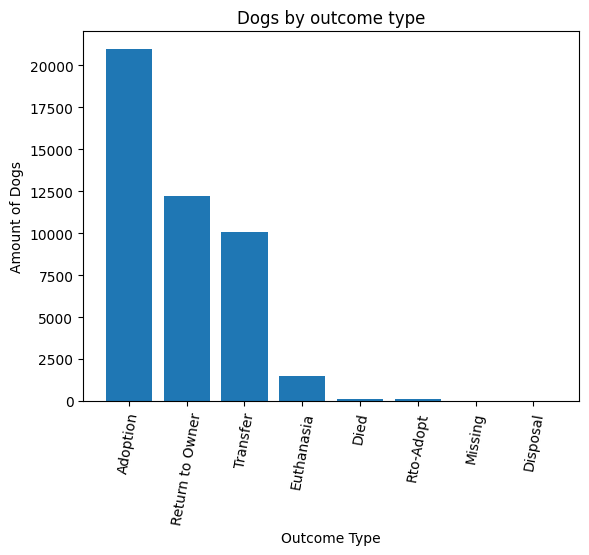

In [968]:
plot_barchart('outcome_type', 'Outcome Type', 'Amount of Dogs', 'Dogs by outcome type')

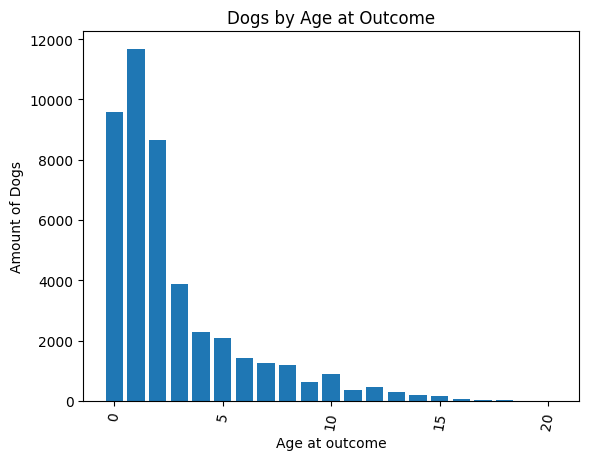

In [970]:
plot_barchart('Age at outcome', 'Amount of Dogs', 'Dogs by Age at Outcome')

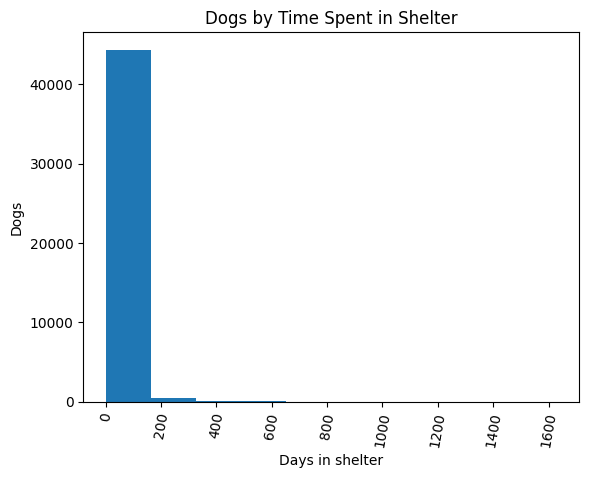

In [971]:
plot_hist(mixed_dogs.total_time_in_shelter.dt.days, 'Days in shelter', 'Dogs', 'Dogs by Time Spent in Shelter')

In [972]:
mixed_dogs.total_time_in_shelter.dt.days.mean()

18.24740987243483

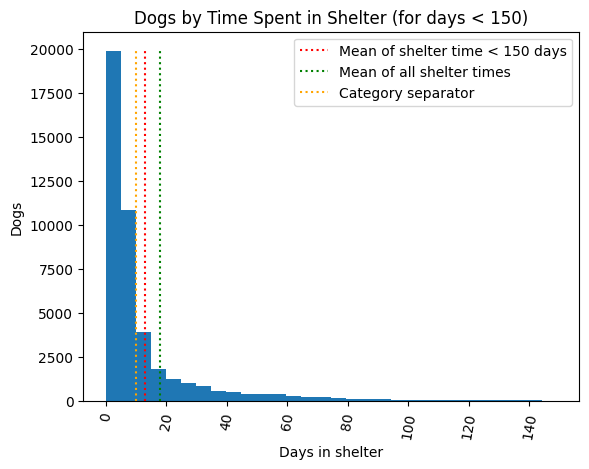

In [973]:
total_time_cut = mixed_dogs.loc[mixed_dogs.total_time_in_shelter.dt.days < 150, 'total_time_in_shelter'].dt.days
plot_hist(total_time_cut, 'Days in shelter', 'Dogs', 'Dogs by Time Spent in Shelter (for days < 150)', bins = 30, show = False)
plt.vlines(13, 0, 20000, color = 'red', linestyles = 'dotted', label = 'Mean of shelter time < 150 days')
plt.vlines(18, 0, 20000, color = 'green', linestyles = 'dotted', label = 'Mean of all shelter times')
plt.vlines(10, 0, 20000, color = 'orange', linestyles = 'dotted', label = 'Category separator')
plt.legend()
plt.show()

In [974]:
mixed_dogs.outcome_type.value_counts()

Adoption           20982
Return to Owner    12248
Transfer           10075
Euthanasia          1468
Died                 150
Rto-Adopt            125
Missing               16
Disposal              10
Name: outcome_type, dtype: int64

In [2349]:
adopted = mixed_dogs.loc[mixed_dogs.outcome_type.isin(['Adoption', 'Rto-Adopt'])].copy()

In [976]:
adopted.shape

(20982, 29)

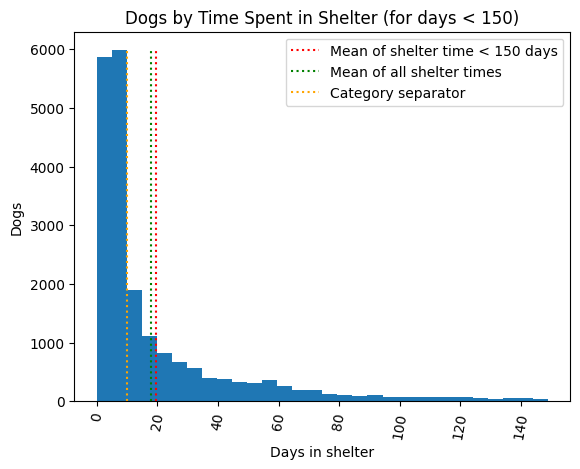

In [2350]:
total_time_cut = adopted.loc[adopted.total_time_in_shelter.dt.days < 150, 'total_time_in_shelter'].dt.days
plot_hist(total_time_cut, 'Days in shelter', 'Dogs', 'Dogs by Time Spent in Shelter (for days < 150)', bins = 30, show = False)
plt.vlines(total_time_cut.mean(), 0, 6000, color = 'red', linestyles = 'dotted', label = 'Mean of shelter time < 150 days')
plt.vlines(18, 0, 6000, color = 'green', linestyles = 'dotted', label = 'Mean of all shelter times')
plt.vlines(10, 0, 6000, color = 'orange', linestyles = 'dotted', label = 'Category separator')
plt.legend()
plt.show()

In [2351]:
total_time_cut.mean()

19.35542521994135

In [2352]:
adopted['days_in_shelter'] = adopted.total_time_in_shelter.dt.days

In [2353]:
adopted.total_time_in_shelter.median()

Timedelta('8 days 01:17:00')

In [2354]:
adopted['adopted_class'] = [1 if days < 8 else 0 for days in adopted.days_in_shelter]

In [982]:
adopted.adopted_class.value_counts()

0    10607
1    10375
Name: adopted_class, dtype: int64

In [983]:
adopted.corr(method = 'spearman')

,avg_height_final,avg_weight_final,avg_expectancy_final,grooming_frequency_value_final,shedding_value_final,energy_level_value_final,trainability_value_final,demeanor_value_final,age_intake,stays_count,age_outcome,days_in_shelter,adopted_class
avg_height_final,1.000000,0.944124,-0.789406,0.238323,0.607297,0.538470,0.460103,0.133118,-0.125580,0.065645,-0.129142,0.165027,-0.148576
avg_weight_final,0.944124,1.000000,-0.833036,0.188808,0.658173,0.497083,0.445865,0.087107,-0.120399,0.068979,-0.123252,0.187404,-0.167401
avg_expectancy_final,-0.789406,-0.833036,1.000000,-0.284595,-0.648563,-0.334820,-0.491904,-0.268909,0.065436,-0.070529,0.069221,-0.187738,0.166387
grooming_frequency_value_final,0.238323,0.188808,-0.284595,1.000000,0.091191,0.112367,0.433688,0.380942,0.000712,0.003781,0.001693,-0.077690,0.068160
shedding_value_final,0.607297,0.658173,-0.648563,0.091191,1.000000,0.477268,0.484660,0.178696,-0.119342,0.041266,-0.122319,0.146961,-0.131637
energy_level_value_final,0.538470,0.497083,-0.334820,0.112367,0.477268,1.000000,0.294152,0.253559,-0.139178,0.025732,-0.139832,0.112852,-0.107023
trainability_value_final,0.460103,0.445865,-0.491904,0.433688,0.484660,0.294152,1.000000,0.421761,-0.091376,0.010312,-0.096163,0.008379,-0.011040
demeanor_value_final,0.133118,0.087107,-0.268909,0.380942,0.178696,0.253559,0.421761,1.000000,-0.021975,0.011621,-0.023588,0.017867,-0.014388
age_intake,-0.125580,-0.120399,0.065436,0.000712,-0.119342,-0.139178,-0.091376,-0.021975,1.000000,0.167569,0.958998,0.263713,-0.245890
stays_count,0.065645,0.068979,-0.070529,0.003781,0.041266,0.025732,0.010312,0.011621,0.167569,1.000000,0.052299,0.265172,-0.251439


In [984]:
adopted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20982 entries, 9 to 45067
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   animal_id                       20982 non-null  object         
 1   breed_0                         20982 non-null  object         
 2   breed_1                         6428 non-null   object         
 3   description_0                   20982 non-null  object         
 4   description_1                   6428 non-null   object         
 5   avg_height_final                20982 non-null  float64        
 6   avg_weight_final                20860 non-null  float64        
 7   avg_expectancy_final            20944 non-null  float64        
 8   grooming_frequency_value_final  20479 non-null  float64        
 9   shedding_value_final            20403 non-null  float64        
 10  energy_level_value_final        20702 non-null  float64   

In [985]:
adopted_features = adopted.copy().drop(columns = ['breed_0', 'breed_1', 'description_0', 'description_1', 'temperament', 'total_time_in_shelter', 'animal_id', 'outcome_subtype'])

In [2066]:
def make_cols_categorical(df):
    for col in df:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].apply(lambda val: str(round(df[col].mean())) if pd.isnull(val) else str(round(val)))
        else:
            df[col] = df[col].apply(lambda val: str(df[col].mean()) if pd.isnull(val) else str(val))
        df[col] = df[col].astype('category')

## Catboost: ##

In [2707]:
adopted_features = adopted[[ 
    # 'avg_height_mixed', 
    'avg_weight_mixed', 
    'avg_expectancy_mixed',
    'grooming_frequency_value_mixed',
    'shedding_value_mixed',
    'energy_level_value_mixed',
    # 'demeanor_value_mixed',
    'age_intake', 
    # 'temperament',
    'group',
    # 'stays_count',
    'color',
    # 'breed_0',
    # 'breed_1',
    'sex_upon_intake',
    # 'description_0',
    'intake_type',
    'intake_condition',
    'adopted_class']].copy()
adopted_features['month_intake'] = adopted.intake_datetime.dt.month
adopted_features['weekday_intake'] = adopted.intake_datetime.dt.weekday
adopted_features['year_intake'] = adopted.intake_datetime.dt.year

### Splitting my data: ###

In [ ]:
# all_colors = ' '.join(adopted_features.temperament.values).replace('/', ' ')
# all_colors_word_count = Counter(all_colors.split(' '))
# all_colors_word_count

In [2073]:
adopted_features.dtypes

avg_height_mixed                     int64
avg_expectancy_mixed              category
grooming_frequency_value_mixed    category
shedding_value_mixed              category
age_intake                        category
group                             category
stays_count                       category
color                             category
sex_upon_intake                   category
intake_type                       category
intake_condition                  category
adopted_class                     category
month_outcome                     category
weekday_outcome                   category
dtype: object

In [2708]:
adopted_features['color'] = adopted_features.color.str.split('/').apply(lambda vals: ' '.join(sorted(vals)))
make_cols_categorical(adopted_features)

In [2709]:
adopted_features.avg_weight_mixed = pd.to_numeric(adopted_features.avg_weight_mixed)
adopted_features.avg_expectancy_mixed = pd.to_numeric(adopted_features.avg_expectancy_mixed)
adopted_features.age_intake = pd.to_numeric(adopted_features.age_intake)
adopted_features.year_intake = pd.to_numeric(adopted_features.year_intake)

In [2784]:
def get_train_valid_test(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.20, random_state=0
    )
    
    X_test, X_valid, y_test, y_valid = train_test_split(
        X_valid, y_valid, test_size=0.50, random_state=0,
    )
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [2785]:
X = adopted_features.drop(columns = ['adopted_class']).copy()
y = adopted_features['adopted_class']

X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_valid_test(X, y)

cat_features = list(X.select_dtypes(include=['object', 'category']).columns)

In [2711]:
model = CatBoostClassifier(
    loss_function = "Logloss",
    iterations = 2000,
    cat_features = cat_features,
    custom_loss=[ 'Accuracy'],
    learning_rate = 0.02,
    early_stopping_rounds=50
)
model.fit(X_train, y_train, eval_set = (X_valid, y_valid), verbose = 200,  plot=True)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6888424	test: 0.6887334	best: 0.6887334 (0)	total: 31.9ms	remaining: 1m 3s
200:	learn: 0.5334419	test: 0.5127544	best: 0.5127544 (200)	total: 4.03s	remaining: 36s
400:	learn: 0.5041673	test: 0.4755339	best: 0.4755339 (400)	total: 7.84s	remaining: 31.3s
600:	learn: 0.4894435	test: 0.4638700	best: 0.4638700 (600)	total: 12.1s	remaining: 28.3s
800:	learn: 0.4785824	test: 0.4575456	best: 0.4575456 (800)	total: 17.3s	remaining: 25.9s
1000:	learn: 0.4697660	test: 0.4545639	best: 0.4545510 (998)	total: 21.8s	remaining: 21.8s
1200:	learn: 0.4622400	test: 0.4520830	best: 0.4520389 (1177)	total: 26.5s	remaining: 17.7s
1400:	learn: 0.4553073	test: 0.4502628	best: 0.4502595 (1399)	total: 32.3s	remaining: 13.8s
1600:	learn: 0.4494984	test: 0.4487162	best: 0.4487162 (1600)	total: 36.6s	remaining: 9.12s
1800:	learn: 0.4432039	test: 0.4478537	best: 0.4478444 (1798)	total: 40.8s	remaining: 4.5s
1999:	learn: 0.4377980	test: 0.4469942	best: 0.4469942 (1999)	total: 45.4s	remaining: 0us

bestTe

In [2376]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 3000,
    'custom_loss': 'Accuracy',
    'learning_rate': 0.02,
    'early_stopping_rounds': 50
}

train_pool = catboost.Pool(
    data = X_train, 
    label = y_train, 
    cat_features = cat_features
)

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=4,
    # shuffle=True,
    partition_random_seed=0,X_train, X_valid, X_test, y_train, y_valid, y_test
    plot=True,
    # stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]

bestTest = 0.4781975165
bestIteration = 2279

Training on fold [1/4]

bestTest = 0.487950803
bestIteration = 2447

Training on fold [2/4]

bestTest = 0.4870921148
bestIteration = 1213

Training on fold [3/4]

bestTest = 0.4746727548
bestIteration = 2978



In [2372]:
from catboost.utils import get_confusion_matrix
train_pool = catboost.Pool(
    data = X_train, 
    label = y_train, 
    cat_features = cat_features
)
get_confusion_matrix(model, train_pool)

array([[7301., 1245.],
       [1060., 7279.]])

In [2373]:
# cb_classifier = catboost.CatBoostClassifier()
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1056
           1       0.76      0.79      0.77      1055

    accuracy                           0.77      2111
   macro avg       0.77      0.77      0.77      2111
weighted avg       0.77      0.77      0.77      2111



In [2314]:
feature_importance = model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,group,18.125176
1,color,10.477078
2,age_intake,10.442401
3,avg_weight_mixed,9.675241
4,month_intake,9.420489
5,year_intake,8.945113
6,weekday_intake,8.482139
7,intake_condition,6.516874
8,sex_upon_intake,6.259554
9,intake_type,4.836314


In [2315]:
adopted_features.dtypes

avg_weight_mixed                     int64
avg_expectancy_mixed                 int64
grooming_frequency_value_mixed    category
shedding_value_mixed              category
energy_level_value_mixed          category
age_intake                           int64
group                             category
color                             category
sex_upon_intake                   category
intake_type                       category
intake_condition                  category
adopted_class                     category
month_intake                      category
weekday_intake                    category
year_intake                          int64
dtype: object

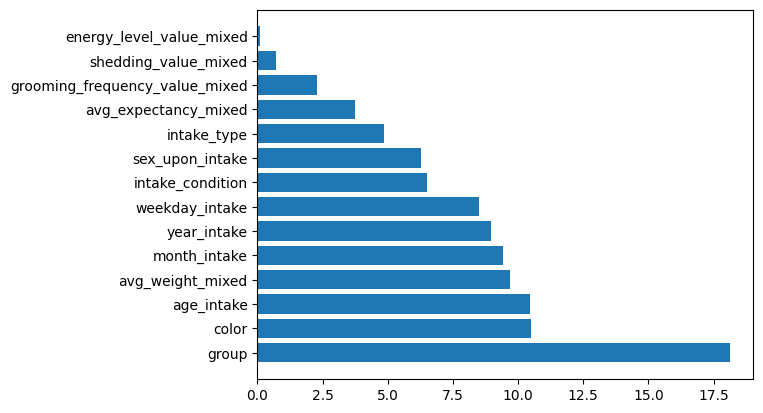

In [2316]:
keys = feature_importance.loc[:, 'Feature Id']
vals = feature_importance.loc[:, 'Importances']

plt.barh(keys, vals)
plt.show()

In [2782]:
import shap

test_pool = catboost.Pool(
    data = X_valid, 
    label = y_valid, 
    cat_features = cat_features
)

shap_values = model.get_feature_importance(
    data=test_pool, 
    type='ShapValues'
)
shap_values = shap_values[:,:-1]

In [1447]:
shap_values

array([[-0.74473817, -0.35551664, -0.04731844, ..., -0.04246754,
        -0.12060982, -0.23731719],
       [ 0.39808986,  0.19898162, -0.04456177, ...,  0.17971801,
         0.36071552,  0.15156265],
       [ 0.48658582,  0.08409392, -0.04685778, ...,  0.13161769,
         0.4808128 ,  0.29381312],
       ...,
       [-0.40468953, -0.07078804, -0.06592936, ...,  0.0979757 ,
         0.11160549, -0.09970684],
       [-0.0379675 , -0.05680694, -0.04061952, ...,  0.13351035,
        -0.1088069 ,  0.02324707],
       [-0.06818764, -0.11868176, -0.0431021 , ...,  0.1248951 ,
        -0.09511484, -0.03630001]])

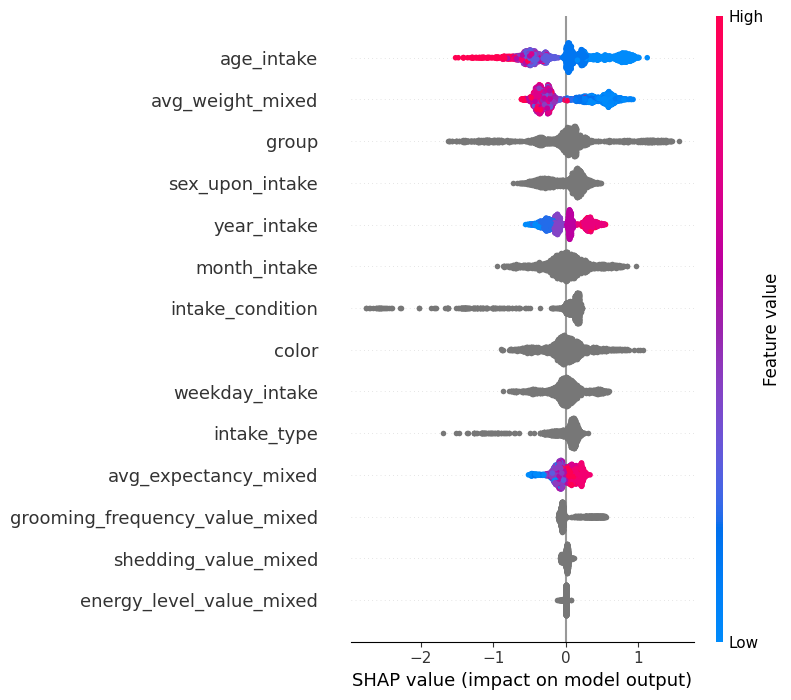

In [2783]:
shap.summary_plot(shap_values, X_valid)

In [2092]:
np.array(model.get_feature_importance(  
    # how much on avg your LOSS FUNC changes if you change your feature value; time consuming :(.
    # Can be negative if you'd rather remove the feature?? Bt could also might mean your model is underfit. 
    # Then overfit it and if its still negative then it's just harmful feature, remove it.
    data=train_pool, 
    type='LossFunctionChange', 
    prettified=True
))

array([['group', 0.028887512312265946],
       ['month_outcome', 0.027261951802486317],
       ['color', 0.026102714879988182],
       ['weekday_outcome', 0.024009876143480203],
       ['age_intake', 0.019985686443432675],
       ['avg_expectancy_mixed', 0.008386173553634418],
       ['avg_height_mixed', 0.004930129199952837],
       ['stays_count', 0.004035042375115126],
       ['sex_upon_intake', 0.0031078609783218025],
       ['grooming_frequency_value_mixed', 0.0017158586809734588],
       ['intake_type', 0.0016876768012767432],
       ['intake_condition', 0.0011081039498411999],
       ['shedding_value_mixed', 0.00011447170558931408]], dtype=object)

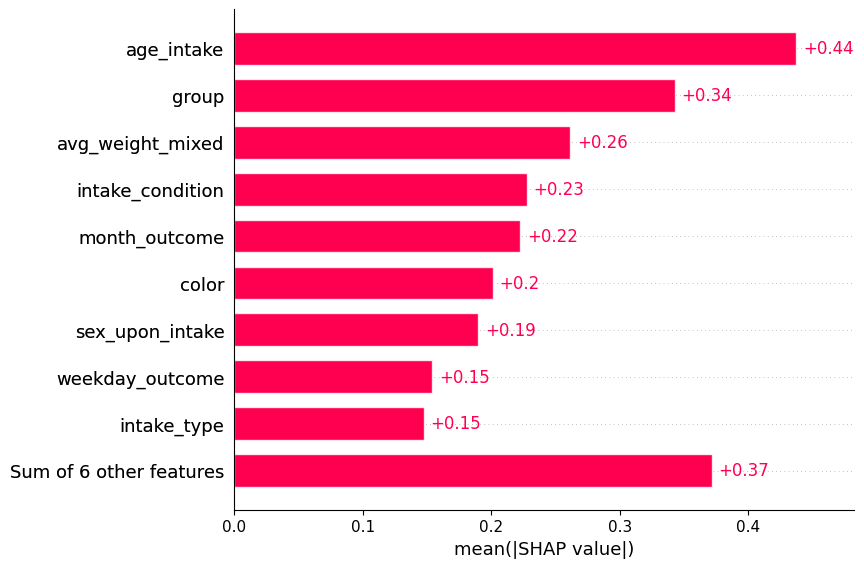

In [2260]:
explainer = shap.Explainer(model)

shap_values = explainer(X_test, y_test)
shap.plots.bar(shap_values)
plt.show()

In [2655]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

ps = PorterStemmer()
all_temperament = ' '.join(adopted.temperament.values).replace('/', ' ')
# all_temperament_word_count = Counter(re.split(r',* ', all_temperament))
stopwords_eng = stopwords.words('english')
all_temperament = [ps.stem(word) for word in re.split(r',* ', all_temperament) if word not in stopwords_eng]
all_temperament_words_count = Counter(all_temperament)

In [2656]:
all_temperament_words_count

Counter({'friendli': 8057,
         'curiou': 3014,
         'spunki': 1258,
         'charm': 4656,
         'grace': 3782,
         'sassi': 3731,
         'activ': 5292,
         'outgo': 4584,
         'merri': 554,
         'confid': 2236,
         'courag': 2117,
         'smart': 5645,
         'loyal': 3836,
         'hardwork': 418,
         'even-temp': 503,
         'alert': 2772,
         'pleasant': 1081,
         'independ': 1110,
         'watch': 478,
         'dignifi': 455,
         'bright': 1131,
         'serious-mind': 163,
         'work-ori': 413,
         'exuber': 413,
         'proud': 857,
         'cheer': 420,
         'busi': 341,
         'inquisit': 741,
         'live': 370,
         'sweet': 38,
         'fun-lov': 887,
         'sensit': 84,
         'clever': 743,
         'athlet': 281,
         'affection': 2768,
         'energet': 899,
         'self-confid': 637,
         'calm': 1085,
         'lovabl': 412,
         'devot': 381,
         'lo

In [2790]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec_temperament = CountVectorizer(
    stop_words = 'english', 
    strip_accents = 'unicode', 
    ngram_range = (1, 2),
    min_df = 200)
count_vec_temperament.fit(adopted.temperament)
count_vec_temperament.vocabulary_
vectors_temp = count_vec_temperament.transform(adopted.temperament)
vectors_temp

<21107x128 sparse matrix of type '<class 'numpy.int64'>'
	with 130075 stored elements in Compressed Sparse Row format>

In [2697]:
def get_NB_preditions(_X_train, _X_test, _y_train):
    model = MultinomialNB()
    model.fit(_X_train, _y_train)
    _y_pred = model.predict(_X_test)
    return _y_pred

In [2791]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,  classification_report
X_t = vectors_temp
y_t = adopted['adopted_class'] 

X_train_temp, X_valid_temp, X_test_temp, y_train_temp, y_valid_temp, y_test_temp = get_train_valid_test(X_t, y_t)

y_pred_temp = get_NB_preditions(X_t_train, X_t_test, y_t_train)
accuracy = accuracy_score(y_t_test, y_pred_temp)
accuracy

0.5997157745144481

In [2796]:
dummy = [random.randint(0,1) for y in y_pred_temp]
accuracy_score(dummy, y_pred_temp)

0.52202747513027

In [2794]:
vectors.shape

(21107, 811)

In [2618]:
two_descr_idxs = ~pd.isnull(adopted['description_1'])
adopted.loc[two_descr_idxs, 'description_0'] = adopted['description_0'] + ' ' + adopted['description_1']

In [2694]:
count_vec_description = CountVectorizer(
    stop_words = 'english', 
    strip_accents = 'unicode', 
    ngram_range = (1, 1),
    min_df = 500)
count_vec_description.fit(adopted.description_0)
count_vec_description.vocabulary_
vectors = count_vec_description.transform(adopted.description_0)
vectors

<21107x811 sparse matrix of type '<class 'numpy.int64'>'
	with 1801868 stored elements in Compressed Sparse Row format>

In [2799]:
X_nb = vectors
y_np = adopted['adopted_class'] 

X_train_nb, X_valid, X_test_nb, y_train_nb, y_valid_nb, y_test_nb = get_train_valid_test(X_nb, y_np)

y_pred_nb = get_NB_preditions(X_train_nb, X_test_nb, y_train_nb)
accuracy = accuracy_score(y_test_nb, y_pred_nb)
accuracy

0.6286120322122217

In [2800]:
cat_pred = model.predict(X_test)
cat_pred = np.array([int(pred) for pred in cat_pred])

In [2801]:
cat_pred * 0.6

array([0. , 0.6, 0. , ..., 0.6, 0.6, 0.6])

In [2802]:
y_pred_temp * 0.2

array([0. , 0.2, 0. , ..., 0.2, 0.2, 0.2])

In [2810]:
combined_pred.shape

(2111,)

In [2831]:
combined_pred = cat_pred * 0.7 + y_pred_temp * 0.1 + y_pred_nb * 0.2
combined_pred

array([0., 1., 0., ..., 1., 1., 1.])

In [2833]:
# combined_pred = np.array(combined_pred, dtype = int)
combined_pred = [str(int(pred)) for pred in combined_pred]


In [2837]:
cat_pred = [str(int(pred)) for pred in cat_pred]

In [2838]:
accuracy = accuracy_score(cat_pred, y_test)
accuracy

0.7702510658455708

## References: ##

<ol>
    <li>
        <a href="https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes">Kaggle dataset - Austin Animal Center Shelter Intakes and Outcomes</a>
    </li>
    <li>
        <a href="https://www.kaggle.com/datasets/mexwell/dog-breeds-dataset">Kaggle dataset - Dog Breeds Dataset AKC</a>
    </li>
    <li>
        <a href="https://www.researchgate.net/publication/373805640_Predicting_Animal_Shelter_Pet_Adoption_Times_and_Feature_Importance_Analysis_using_CatBoost">Predicting Animal Shelter Pet Adoption Times and Feature Importance Analysis using CatBoost</a>
    </li>
    <li>
        <a href="https://catboost.ai/en/docs/concepts/tutorials">CatBoost Functionality Introduction</a>
    </li>
</ol>
